<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [3]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [5]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [6]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

In [7]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [8]:
# Load the DataFrames from the .pkl files
# with open("../data/train_df.pkl", "rb") as f:
#     train_df = pickle.load(f)

# with open("../data/valid_df.pkl", "rb") as f:
#     valid_df = pickle.load(f)

# with open("../data/test_df.pkl", "rb") as f:
#     test_df = pickle.load(f)

In [9]:
# Encode family (target) and phylum (metadata feature)
family_encoder = LabelEncoder()
phylum_encoder = LabelEncoder()
df["family_encoded"] = family_encoder.fit_transform(df["family"])
df["phylum_encoded"] = phylum_encoder.fit_transform(df["phylum"])

# Check the number of unique families and phyla
num_families = df["family_encoded"].nunique()
num_phyla = df["phylum_encoded"].nunique()
print(f"Number of unique phyla: {num_phyla}")
print(f"Number of unique families: {num_families}")

# One-hot encode the family and phylum columns
df["phylum_onehot"] = df["phylum_encoded"].apply(lambda x: tf.one_hot(x, depth=num_phyla).numpy())
df["family_onehot"] = df["family_encoded"].apply(lambda x: tf.one_hot(x, depth=num_families).numpy())

# Create a new column for the full file path
# Windows
# df["full_file_path"] = df["file_path"].apply(lambda x: os.path.join(path, x.replace("/", "\\")))
# Mac
df["full_file_path"] = df["file_path"].apply(lambda x: str(Path("../data/rare_species") / x))

# Increase display width
# pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
df.head()

2025-04-15 21:29:47.008336: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3


Number of unique phyla: 5
Number of unique families: 202


2025-04-15 21:29:47.010357: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-15 21:29:47.012147: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-15 21:29:47.013436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-15 21:29:47.013457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  family_encoded  \
0  mollusca_unionidae/12853737_449393_eol-full-si...             193   
1  chordata_geoemydidae/20969394_793083_eol-full-...              84   
2  chordata_cryptobranchidae/28895411_319982_eol-...              56   
3  chordata_turdidae/29658536_45510188_eol-full-s...             192   
4  chordata_indriidae/21252576_7250886_eol-full-s...             100   

   phylum_encoded              phylum_onehot  \
0               4  [0.0, 0.0, 0.0, 0.0, 1.0]   
1               1  [0.0, 1.0, 0.0, 0.0, 0.0]   
2               1  [0.0, 1.0, 0.0, 0.0, 0.0]   
3               1  [0.0, 1.0, 0.0, 0.0, 0.0]   
4               1  [0.0, 1.0, 0.0, 0.0, 0.0]   

                                       family_onehot  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                      full_file_path  
0  ../data/rare_species/mollusca_unionidae/128537...  
1  ../data/rare_species/chordata_geoemydidae/2096...  
2  ../data/rare_species/chordata_cryptobranchidae...  
3  ../data/rare_species/chordata_turdidae/2965853...  
4  ../data/rare_species/chordata_indriidae/212525...

In [10]:
# # Split the data into training, validation, and testing sets
train_df, test_valid_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42, stratify=df['family'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, shuffle=True, random_state=42, stratify=test_valid_df['family'])

In [11]:
# Organize the data into train/val/test directories
image_base_path = Path("../data/rare_species")
base_output_dir = image_base_path

# Copy the images to the new directories
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df, copy=False, split_name="train")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=valid_df, copy=False, split_name="val")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=test_df, copy=False, split_name="test")

# Clean up unnecessary folders
cleanup_folders(image_base_path)

Not found: ../data/rare_species/chordata_ranidae/21985147_2920193_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_bufonidae/14130545_332433_eol-full-size-copy.jpg
Not found: ../data/rare_species/cnidaria_agariciidae/21699220_45276518_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hexanchidae/29652508_46560148_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_geoemydidae/29538706_793083_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_cervidae/15265090_308403_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hylobatidae/28175522_1038643_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_mesitornithidae/28312603_915363_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_sparidae/21866390_46580005_eol-full-size-copy.jpg
Not found: ../data/rare_species/arthropoda_formicidae/29369457_460290_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_balaenopteridae/21756543_46559441_eol-

In [12]:
# Update the file paths to point to the new directories
train_df = update_paths(train_df, "train")
valid_df = update_paths(valid_df, "val")
test_df = update_paths(test_df, "test")

In [13]:
# sampling train
train_df_sampled, _ = train_test_split(train_df, test_size=0.5, shuffle=True, random_state=42, stratify=train_df['family'])
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df_sampled, copy=True, split_name="train_sampled")
train_df_sampled = update_paths(train_df_sampled, "train_sampled")

In [14]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [15]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment='mixup', oversampling=True)
train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment='mixup', oversampling=True)
val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

Found 8388 files belonging to 202 classes.
Found 4194 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


2025-04-15 21:31:02.084620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


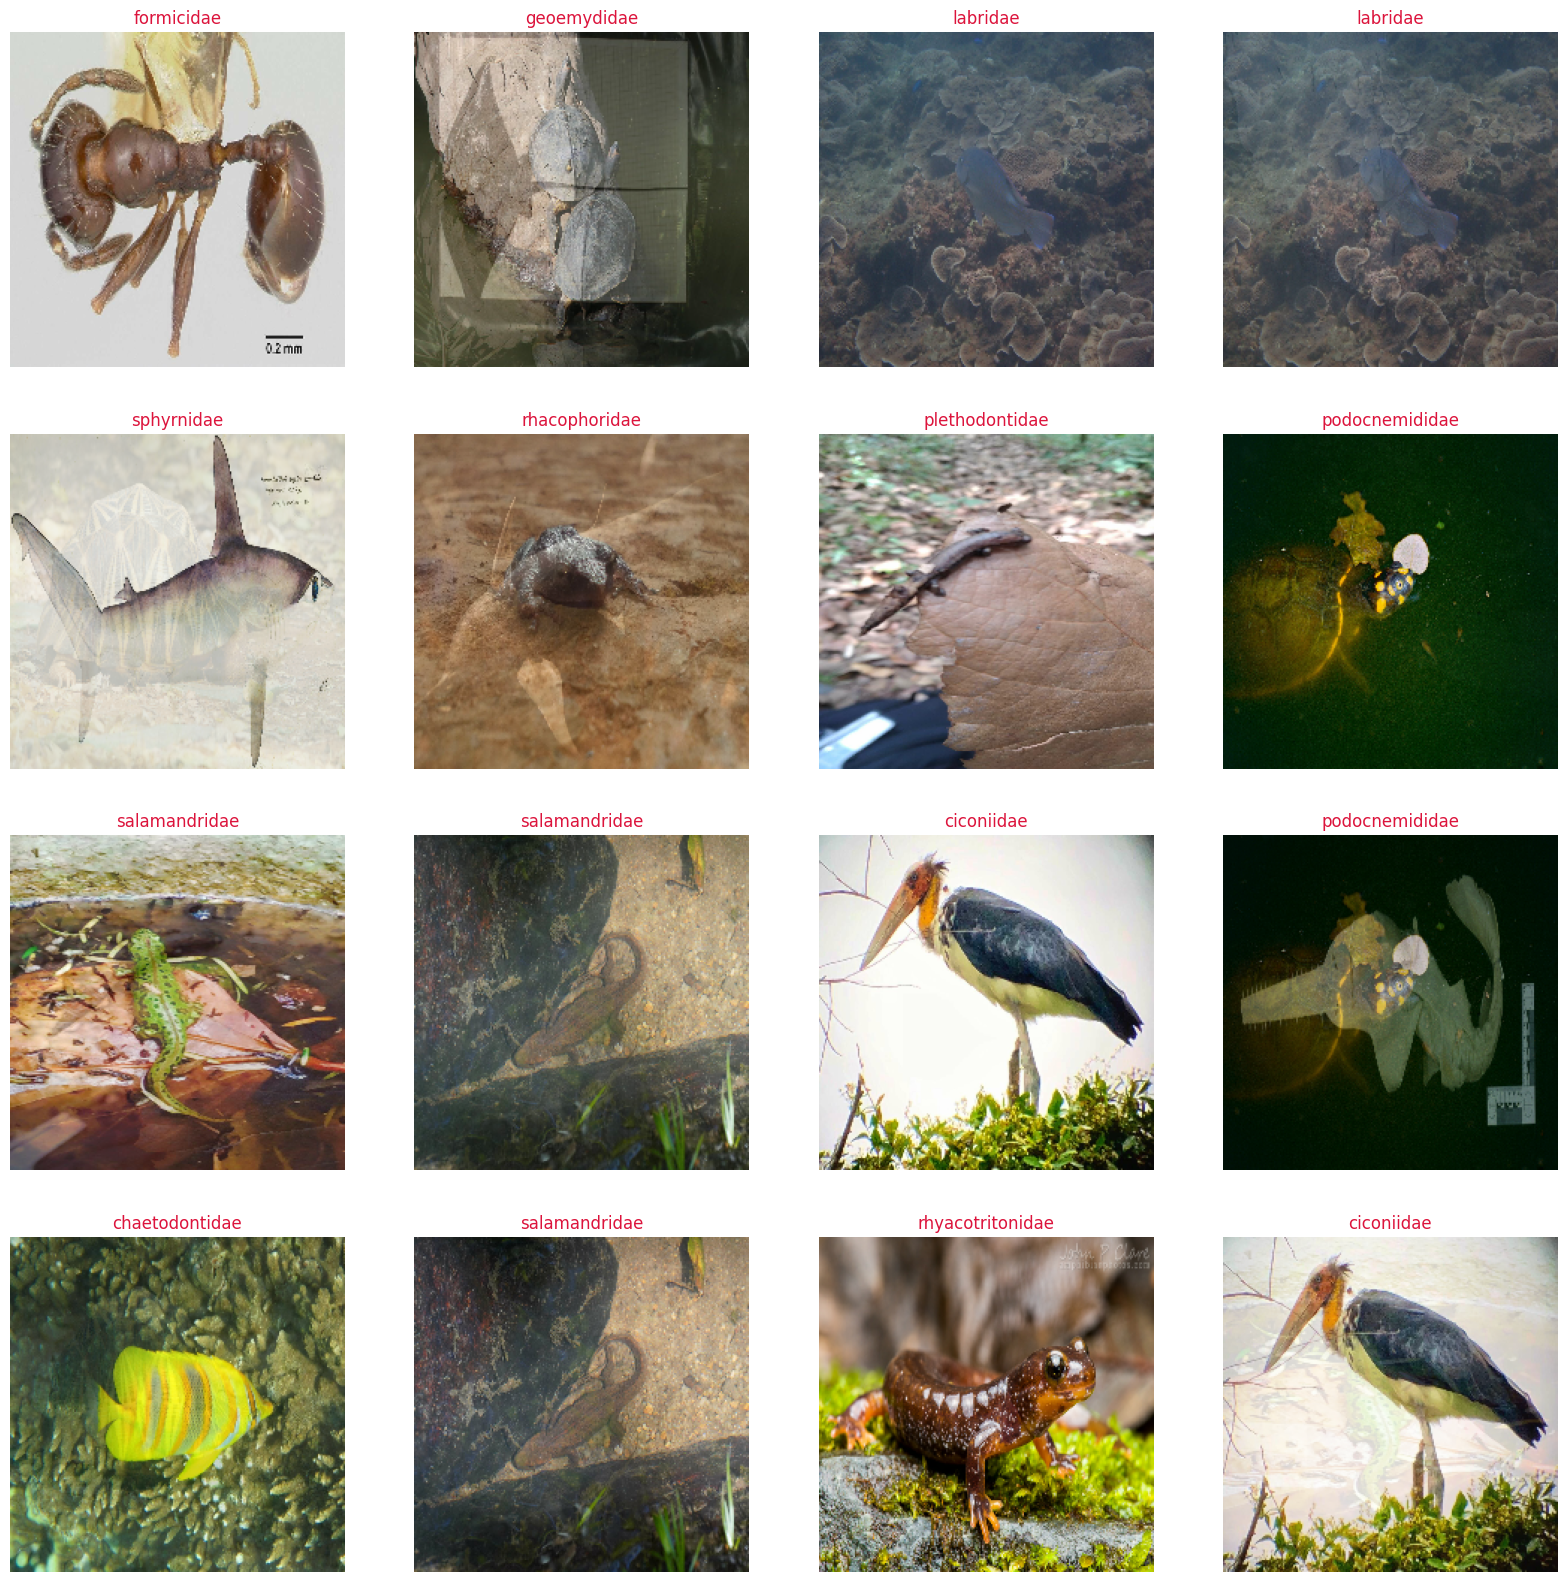

In [16]:
num_images = 16 ##
rows, cols = 4, 4 ##

plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

## 5.2 Augmentations

In [17]:
# augmentations_to_test = [
#     # "none",
#     # "light",
#     # "medium",
#     # "heavy",
#     # "grayscale",
#     # "randaugment",
#     "mixup",
#     "cutmix"]

<!-- ##### Simple model do test augmentations -->

In [18]:
# def build_model(num_classes):
#     base = keras.applications.EfficientNetB0(
#         input_shape=(224, 224, 3),
#         include_top=False,
#         weights="imagenet",
#         pooling="avg"
#     )
#     base.trainable = False  # You can fine-tune later

#     inputs = keras.Input(shape=(224, 224, 3))
#     x = base(inputs, training=False)
#     x = keras.layers.Dropout(0.2)(x)
#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     return keras.Model(inputs, outputs)

In [19]:
# def sample_dataset(dataset, fraction=None, num_batches=None, seed=42):
#     """Return a sampled subset of the dataset."""
#     if fraction:
#         dataset = dataset.shuffle(1000, seed=seed)
#         dataset = dataset.take(int(fraction * tf.data.experimental.cardinality(dataset).numpy()))
#     elif num_batches:
#         dataset = dataset.take(num_batches)
#     return dataset

<!-- ##### Loop -->

In [20]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=5,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


In [21]:
# augmentations_to_test = [
#     "none",
#     "light",
#     "medium",
#     "heavy",
#     "grayscale",
#     "randaugment",
#     "mixup",
#     "cutmix"]

In [22]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=15,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


<div class="alert alert-block alert-success">

# **3.** Models

<div>

In [23]:
def lr_schedule(epoch):
    warmup_epochs = 3         # Reduced warmup period
    base_lr = 1e-3            # Higher starting LR
    max_lr = 1e-2             # Maximum LR after warmup
    decay_rate = 0.95         # Slightly slower decay

    if epoch < warmup_epochs:
        return base_lr + (max_lr - base_lr) * (epoch / warmup_epochs)
    else:
        return max_lr * (decay_rate ** (epoch - warmup_epochs))


In [24]:
# Add callbacks
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
lr_callback = LearningRateScheduler(lr_schedule)

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    lr_callback
]

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_optimized_model(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    # Shared conv base
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Parallel paths
    conv1 = Conv2D(32, (1, 1), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    conv3 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    conv5 = Conv2D(32, (5, 5), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)

    x = Concatenate()([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Another conv block
    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Final feature compression
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Build and compile
model = build_optimized_model()

In [26]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        "accuracy"
    ]
)

In [27]:
# # Initialize the experiment
# experiment = Experiment(
#     model=model,
#     train_ds=train_ds_sampled,
#     val_ds=val_ds,
#     experiment_name="parallel_mixup_withou_phylum",
#     batch_size=32,
#     image_size=(224, 224)
# )

# # Default callbacks
# # ExperimentLogger,  # Log experiment results after each epoch
# # EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# # ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# # Run the experiment
# history = experiment.run_experiment(callbacks=callbacks, epochs=50) # callbacks=None use default callbacks (created in the Experiment class)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_simple_functional_cnn(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)
    
    # Block 1: Extract low-level features.
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (112, 112, 32)
    
    # Block 2: Increase depth with more complex features.
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (56, 56, 64)
    
    # Block 3: Extract even higher-level representations.
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (28, 28, 128)
    
    # Global Feature Aggregation
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    # Dense layers for classification
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = build_simple_functional_cnn()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 202)            │        51,914 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,082 (699.54 KB)

 Trainable params: 178,634 (697.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
callbacks = callbacks +  [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [33]:
history = model.fit(
    train_ds_sampled,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Optionally, you can inspect the training history:
print(history.history)

Epoch 1/10


175/175 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.0095 - loss: 5.8826 - val_accuracy: 0.0273 - val_loss: 5.2290 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 63s 355ms/step - accuracy: 0.0088 - loss: 6.3158 - val_accuracy: 0.0161 - val_loss: 6.2324 - learning_rate: 0.0040
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0098 - loss: 7.8005
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035000001080334187.
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 435ms/step - accuracy: 0.0098 - loss: 7.8009 - val_accuracy: 0.0078 - val_loss: 13.8024 - learning_rate: 0.0035
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 438ms/step - accuracy: 0.0070 - loss: 7.6631 - val_accuracy: 0.0178 - val_loss: 8.0339 - learning_rate: 0.0100
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.0124 - loss: 6.0030
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004749999847263098.
175/175 ━━━━━━━━━━━━━━━━━━━━ 79s 453ms/step - accuracy: 0.0124 - loss: 6.0

In [34]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="hybrid_cnn_transformer_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/10


2025-04-15 19:17:43.119067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


135/175 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - accuracy: 0.0072 - loss: 5.7882

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, ReLU, Add,
                                     GlobalAveragePooling2D, Reshape, Multiply, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def se_block(input_tensor, reduction=16):
    """Squeeze-and-Excitation block."""
    channel_dim = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)  # Squeeze: (batch, channels)
    se = Dense(channel_dim // reduction, activation='relu', kernel_regularizer=l2(1e-4))(se)
    se = Dense(channel_dim, activation='sigmoid', kernel_regularizer=l2(1e-4))(se)
    se = Reshape((1, 1, channel_dim))(se)
    x = Multiply()([input_tensor, se])
    return x

def residual_se_block(x, filters, kernel_size=(3,3), stride=1):
    shortcut = x
    # First conv layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    # Second conv layer
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Apply SE block
    x = se_block(x)
    
    # If dimensions differ, use a projection shortcut.
    if stride != 1 or int(shortcut.shape[-1]) != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

def build_custom_se_resnet(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)
    
    # Initial Block
    x = Conv2D(64, (7, 7), strides=2, padding="same", activation="relu", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=2, padding="same")(x)
    
    # Residual SE Blocks
    x = residual_se_block(x, 64, kernel_size=(3, 3), stride=1)
    x = residual_se_block(x, 64, kernel_size=(3, 3), stride=1)
    
    x = residual_se_block(x, 128, kernel_size=(3, 3), stride=2)
    x = residual_se_block(x, 128, kernel_size=(3, 3), stride=1)
    
    x = residual_se_block(x, 256, kernel_size=(3, 3), stride=2)
    x = residual_se_block(x, 256, kernel_size=(3, 3), stride=1)
    
    # Global Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs, outputs)

# Build and compile the model
model = build_custom_se_resnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="custom_se_resnet_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)